In [34]:
import tensorflow as tf
import numpy as np 
import cv2
import matplotlib.pyplot as plt
import keras
from keras import backend as K

## Dataset

In [28]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# train set / data 
x_train = x_train.astype('float32') / 255
# train set / target 
y_train = tf.keras.utils.to_categorical(y_train , num_classes=10)

# validation set / data 
x_test = x_test.astype('float32') / 255
# validation set / target 
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [29]:
#reduce dataset size
x_train = x_train[1:100]
y_train = y_train[1:100]

x_test = x_test[1:15]
y_test = y_test[1:15]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)  


(99, 32, 32, 3) (99, 10)
(14, 32, 32, 3) (14, 10)


In [30]:
print(type(x_train[0]))

<class 'numpy.ndarray'>


## Model & Metrics

In [31]:
def get_metrics() :
  return [
      # keras.metrics.TruePositives(name='tp'),
      # keras.metrics.FalsePositives(name='fp'),
      # keras.metrics.TrueNegatives(name='tn'),
      # keras.metrics.FalseNegatives(name='fn'), 
      # keras.metrics.BinaryAccuracy(name='accuracy'),
      # keras.metrics.Precision(name='precision'),
      # keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR')] # precision-recall curve


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [38]:
input = tf.keras.Input(shape=(32,32,3))
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet',
                                             include_top = False, 
                                             input_tensor = input)

# base_model = tf.keras.applications.DenseNet121(weights='imagenet',
#                                          include_top = False,
#                                          input_tensor = input)

# base_model = tf.keras.applications.ResNet18(weights='imagenet',
#                                          include_top = False,
#                                          input_tensor = input)

# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(base_model.output)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation='softmax')(gap)

# bind all
model = tf.keras.Model(base_model.input, output)

#freeze layers
for layer in base_model.layers:
    layer.trainable = True

## Compile and Run

In [41]:
model.compile(
          loss      = tf.keras.losses.CategoricalCrossentropy(),
          metrics   = [tf.keras.metrics.CategoricalAccuracy(),  
                       f1_m,precision_m, 
                       recall_m, 
                       get_metrics()],
          optimizer = tf.keras.optimizers.Adam())
# fit 
model_h = model.fit(x_train, y_train, batch_size=128, epochs=2, verbose = 2)

Epoch 1/2
1/1 - 14s - loss: 1.0477 - categorical_accuracy: 0.7071 - f1_m: 0.5324 - precision_m: 0.9250 - recall_m: 0.3737 - auc: 0.9584 - prc: 0.8038
Epoch 2/2
1/1 - 1s - loss: 0.7206 - categorical_accuracy: 0.8586 - f1_m: 0.7421 - precision_m: 0.9833 - recall_m: 0.5960 - auc: 0.9741 - prc: 0.8704


## Training History

KeyError: 'val_loss'

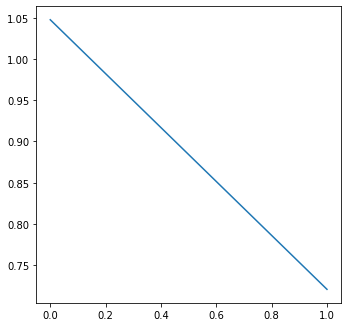

In [42]:
plt.rcParams["figure.figsize"] = (12,12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'accuracy', 'f1_m', 'recall_m']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(model_h)

## Prediction

In [14]:
image = cv2.imread('dog.jpeg')
image = cv2.resize(image, (32, 32))
image = image.astype('float32') / 255
image = np.expand_dims(image, axis=0)

preds = func_model.predict(image) 
i = np.argmax(preds[0])
print(image.shape)

(1, 32, 32, 3)


## Grad CAM

In [15]:
for idx in range(len(func_model.layers)):
  print(func_model.get_layer(index = idx).name)

input_2
rescaling_1
normalization_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

In [18]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            
            loss = predictions[:, tf.argmax(predictions[0])]
    
        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

In [21]:
icam = GradCAM(model, i, 'block7a_project_conv')  # efnet'block5c_project_conv'
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (32, 32))

image = cv2.imread('dog.jpeg')
image = cv2.resize(image, (32, 32))

print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(32, 32) (32, 32, 3)


## Visualization

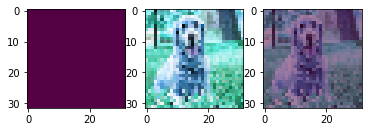

In [22]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)